# Collaboration and Competition

---

In this notebook, you will learn how to use the Unity ML-Agents environment for the third project of the [Deep Reinforcement Learning Nanodegree](https://www.udacity.com/course/deep-reinforcement-learning-nanodegree--nd893) program.



<div class="alert alert-block alert-warning">
<b>Caution:</b> You will need to create the proper python virtual environment.  The environment specifications can be found in the requirements.txt file.
<br>
Using Anaconda is recommended.  To begin, execute the code below from your anaconda command prompt:<br>
<br>
$ conda env create -f environment.yaml
<br>
<br>
Then navigate to the directory for this project where you downloaded it on your PC and launch jupyter notebook from there.
</div>

### 1. Start the Environment

We begin by importing the necessary packages.  If the code cell below returns an error, please revisit the project instructions to double-check that you have installed [Unity ML-Agents](https://github.com/Unity-Technologies/ml-agents/blob/master/docs/Installation.md) and [NumPy](http://www.numpy.org/).

In [1]:
from unityagents import UnityEnvironment
import numpy as np
import random
import copy
from itertools import chain
import os
from tensorboardX import SummaryWriter
import torch
from torch.autograd import Variable
import matplotlib.pyplot as plt
import sys
sys.setrecursionlimit(1500)
%matplotlib inline

Next, we will start the environment!  **_Before running the code cell below_**, change the `file_name` parameter to match the location of the Unity environment that you downloaded.

- **Mac**: `"path/to/Tennis.app"`
- **Windows** (x86): `"path/to/Tennis_Windows_x86/Tennis.exe"`
- **Windows** (x86_64): `"path/to/Tennis_Windows_x86_64/Tennis.exe"`
- **Linux** (x86): `"path/to/Tennis_Linux/Tennis.x86"`
- **Linux** (x86_64): `"path/to/Tennis_Linux/Tennis.x86_64"`
- **Linux** (x86, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86"`
- **Linux** (x86_64, headless): `"path/to/Tennis_Linux_NoVis/Tennis.x86_64"`

For instance, if you are using a Mac, then you downloaded `Tennis.app`.  If this file is in the same folder as the notebook, then the line below should appear as follows:
```
env = UnityEnvironment(file_name="Tennis.app")
```

In [2]:
env = UnityEnvironment(file_name="Tennis_Windows_x86_64/Tennis.exe")

INFO:unityagents:
'Academy' started successfully!
Unity Academy name: Academy
        Number of Brains: 1
        Number of External Brains : 1
        Lesson number : 0
        Reset Parameters :
		
Unity brain name: TennisBrain
        Number of Visual Observations (per agent): 0
        Vector Observation space type: continuous
        Vector Observation space size (per agent): 8
        Number of stacked Vector Observation: 3
        Vector Action space type: continuous
        Vector Action space size (per agent): 2
        Vector Action descriptions: , 


Environments contain **_brains_** which are responsible for deciding the actions of their associated agents. Here we check for the first brain available, and set it as the default brain we will be controlling from Python.

In [3]:
# get the default brain
brain_name = env.brain_names[0]
brain = env.brains[brain_name]

### 2. Examine the State and Action Spaces

In this environment, two agents control rackets to bounce a ball over a net. If an agent hits the ball over the net, it receives a reward of +0.1.  If an agent lets a ball hit the ground or hits the ball out of bounds, it receives a reward of -0.01.  Thus, the goal of each agent is to keep the ball in play.

The observation space consists of 8 variables corresponding to the position and velocity of the ball and racket. Two continuous actions are available, corresponding to movement toward (or away from) the net, and jumping. 

Run the code cell below to print some information about the environment.

In [4]:
# reset the environment
env_info = env.reset(train_mode=True)[brain_name]

# number of agents 
num_agents = len(env_info.agents)
print('Number of agents:', num_agents)

# size of each action
action_size = brain.vector_action_space_size
print('Size of each action:', action_size)

# examine the state space 
states = env_info.vector_observations
state_size = states.shape[1]
print('There are {} agents. Each observes a state with length: {}'.format(states.shape[0], state_size))
print('The state for the first agent looks like:', states[0])

Number of agents: 2
Size of each action: 2
There are 2 agents. Each observes a state with length: 24
The state for the first agent looks like: [ 0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.          0.          0.
  0.          0.          0.          0.         -6.65278625 -1.5
 -0.          0.          6.83172083  6.         -0.          0.        ]


### 3. Take Random Actions in the Environment

In the next code cell, you will learn how to use the Python API to control the agents and receive feedback from the environment.

Once this cell is executed, you will watch the agents' performance, if they select actions at random with each time step.  A window should pop up that allows you to observe the agents.

Of course, as part of the project, you'll have to change the code so that the agents are able to use their experiences to gradually choose better actions when interacting with the environment!

In [5]:
for i in range(1, 2):                                      # play game for 5 episodes
    env_info = env.reset(train_mode=False)[brain_name]     # reset the environment    
    states = env_info.vector_observations                  # get the current state (for each agent)
    scores = np.zeros(num_agents)                          # initialize the score (for each agent)
    while True:
        actions = np.random.randn(num_agents, action_size) # select an action (for each agent)
        actions = np.clip(actions, -1, 1)                  # all actions between -1 and 1
        env_info = env.step(actions)[brain_name]           # send all actions to tne environment
        next_states = env_info.vector_observations         # get next state (for each agent)
        rewards = env_info.rewards                         # get reward (for each agent)
        dones = env_info.local_done                        # see if episode finished
        scores += env_info.rewards                         # update the score (for each agent)
        states = next_states                               # roll over states to next time step
        if np.any(dones):                                  # exit loop if episode finished
            break
    print('Score (max over agents) from episode {}: {}'.format(i, np.max(scores)))

Score (max over agents) from episode 1: 0.0


<div class="alert alert-block alert-warning">
<b>Caution:</b> When finished, please leave the unity window open.  If you accidentally closed, shut down the kernel, relaunch the notebook and rerun the cells above.
</div>

### 4. Building our Actor and Critic Networks using Pytorch

In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [7]:
def hidden_init(layer):
    fan_in = layer.weight.data.size()[0]
    lim = 1. / np.sqrt(fan_in)
    return (-lim, lim)

The below 'Actor' class builds an actor (policy) network that will map states to actions. Note the use of relu activation functions and batch normalization.

In [8]:
class Actor(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fc1_units = 128, fc2_units = 64):    
        
        # initializing model parameters
        
        super(Actor, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fc1 = nn.Linear(state_size, fc1_units)
        self.fc2 = nn.Linear(fc1_units, fc2_units)
        self.fc3 = nn.Linear(fc2_units, action_size)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.bn1 = nn.BatchNorm1d(fc1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.bn3 = nn.BatchNorm1d(action_size)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fc1.weight.data.uniform_(*hidden_init(self.fc1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state):
        state = self.bn0(state)
        x = self.bn1(F.relu(self.fc1(state)))
        x = self.bn2(F.relu(self.fc2(x)))
        x = self.bn3(F.relu(self.fc3(x)))
        return F.tanh(x)

The below 'Critic' class builds a critic (value) network that maps state,action pairs to Q-values

In [9]:
class Critic(nn.Module):
    
    def __init__(self, state_size, action_size, seed, fcs1_units = 128, fc2_units = 64):    
        
        # initializing model parameters
        
        super(Critic, self).__init__()
        self.seed = torch.manual_seed(seed)
        self.fcs1 = nn.Linear(state_size, fcs1_units)
        self.fc2 = nn.Linear(fcs1_units + action_size, fc2_units)
        self.fc3 = nn.Linear(fc2_units, 1)
        self.bn0 = nn.BatchNorm1d(state_size)
        self.bn1 = nn.BatchNorm1d(fcs1_units)
        self.bn2 = nn.BatchNorm1d(fc2_units)
        self.reset_parameters()
        
    def reset_parameters(self):
        self.fcs1.weight.data.uniform_(*hidden_init(self.fcs1))
        self.fc2.weight.data.uniform_(*hidden_init(self.fc2))
        self.fc3.weight.data.uniform_(-3e-3, 3e-3)
        
    def forward(self, state, action):
        state = self.bn0(state)
        xs = self.fcs1(state)
        xs = self.bn1(xs)
        xs = F.leaky_relu(xs)
        x = torch.cat((xs, action), dim = 1)
        x = self.fc2(x)
        x = self.bn2(x)
        x = F.leaky_relu(x)
        x = self.fc3(x)
        return x

<div class="alert alert-block alert-info">
<b>Insights from model architectures:</b> <br>
<br>
Model architectures were important in the successful training of the agents.  Two layer architectures worked best with 128 and 64 hidden units respectively and any deviation from these levels resulted in decreases in performance.  Both the actor and critic models needed extensive batch-normalization on almost every layer in order to learn properly.
</div>

### 5. Creating a Noise Class to encourage exploration 

In [10]:
class Noise:
    
    def __init__(self, size, seed, mu = 0., theta = 0.15, sigma = 0.1, dt = 1):
        
        self.mu = mu * np.ones(size)
        self.theta = theta
        self.sigma = sigma
        self.seed = random.seed(seed)
        self.dt = dt
        self.size = size
        self.reset()
        
    def reset(self):
        
        # reset the noise to mean mu
        
        self.state = copy.copy(self.mu)
        
    def sample(self):
        
        x = self.state
        dx = self.theta * (self.mu - x) * self.dt + self.sigma * np.sqrt(self.dt) * np.array([np.random.randn() for i in range(len(x))])
        self.state = x + dx
        return self.state

<div class="alert alert-block alert-info">
<b>Insights from noise:</b> <br>
<br>
The initial DDPG implementation applied the random.random function instead of the np.random.randn function now used.  This was a problem given that random.random drew from a uniform distribution which significantly skewed the noise in one direction.  The np.random.rand function draws from a gaussian distribution which eliminates this skew.  Another learning was to keep the values of dt in the class to 1 (or exclude alltogether).  In other DDPG github implementations involving other environments, dt was used with a small value (~1e-2) which suppresses the noise.  While that may be helpful in other environments, it was detrimental here.  Finally, the value for sigma needed to be reduced to 0.1 from the 0.2 value used on the prior project.  This change effectively constrained the noise distribution by half.

</div>

### 6. Building a Replay Buffer for our Agent

In [11]:
from collections import namedtuple, deque

class ReplayBuffer:
    
    def __init__(self, action_size, buffer_size, batch_size, seed):
        
        # initialize parameters
        self.buffer_size = buffer_size
        self.action_size = action_size
        self.memory = deque(maxlen = self.buffer_size)
        self.batch_size = batch_size
        self.experience = namedtuple("Experience", 
                                     field_names = ["state", "action", "reward", "next_state", "done"])
        self.seed = random.seed(seed)
        
    def add(self, state, action, reward, next_state, done):
        
        # add a new experience to memory
        
        e = self.experience(state, action, reward, next_state, done)
        self.memory.append(e)
        
    def sample(self):
        
        # randomly sample a batch of experiences from memory
        
        experiences = random.sample(self.memory, k = self.batch_size) #self.batch_size)
        
        states = torch.from_numpy(np.vstack([e.state for e in experiences if e is not None])).float().to(device)
        actions = torch.from_numpy(np.vstack([e.action for e in experiences if e is not None])).float().to(device)
        rewards = torch.from_numpy(np.vstack([e.reward for e in experiences if e is not None])).float().to(device)
        next_states = torch.from_numpy(np.vstack([e.next_state for e in experiences if e is not None])).float().to(device)
        dones = torch.from_numpy(np.vstack([e.done for e in experiences if e is not None]).astype(np.uint8)).float().to(device)
        
        return (states, actions, rewards, next_states, dones)
    
    def __len__(self):
        
        return len(self.memory)

<div class="alert alert-block alert-info">
<b>Insights from replay buffer designs:</b> <br>
<br>
The replay buffer utilized the same design as in the prior project.  Its two functions, add and sample, respectively add experience tuples to memory and randomly sample experience tuples from memory in order to aid in the learning process for the agents.

</div>

### 7. Initializing Hyperparameters

In [12]:
BUFFER_SIZE = int(1000000)                                              # replay buffer size
BATCH_SIZE = 200                                                        # minibatch size
GAMMA = 0.99                                                            # discount factor
TAU = 0.001                                                             # for soft update of target parameters
LR_ACTOR = 0.0012                                                       # learning rate of the actor
LR_CRITIC = 0.001                                                       # learning rate of the critic
WEIGHT_DECAY = 0.00000                                                  # L2 weight decay (not used in final solution)
LEARN_EVERY_T = 20                                                      # num time steps between each net update
LR_DECAY = .000000                                                      # learning rate decay factor (not used in final solution)
NB_AGENTS = 2                                                           # number of agents
UPDATES_EACH_STEP = 10                                                  # number of updates to make every 'LEARN_EVERY_T' steps
NOISE_DECAY = 0.000                                                     # amount noise is set to decay each step (not used)
NOISE_FACTOR = 1.0                                                      # starting level of noise as % (not used in final solution)    
NOISE_MIN = 0.1                                                         # minimum noise to keep (not used in final solution)

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

<div class="alert alert-block alert-info">
<b>Insights from hyperparameters:</b> <br>
<br>
<b>Batch size -</b> differing batch sizes did not result in significant changes in performance 
<br>
<b>Gamma -</b>  The discount factor for future rewards.  Differing values of gamma between 0.99 and 1.0 did not change performance.  The objective is for the agents to keep the ball in the air as long as possible, so a high level of gamma needed to be maintained.
<br>
<b>TAU -</b>  Tau is used for the soft update of the target model parameters from the current model parameters.  Most implementations favor a value of 0.001 which was used in the end.  I ran an experiments in increasing the values for tau, but they resulted in significant declines in performance.
<br>
<b>Learning rates -</b>  While the ideal learning rate for the critic (0.001) was similar to those used in other DDPG implementations, the learning rate needed for the actor was much higher.  This was interesting given most DDPG implementations used a value of 0.0001.  The ideal actor learning rates for these agents was 12X higher at 0.0012.  This may be due to larger changes needing to be made in a shorter duration of time in order to capitalize on the rare observations where both agents are able to pass the ball to each other in the early stages of training.
<br>
<b>Weight decay -</b>  Used for regularization.  Weight decay did not help in training performance and therefore the value was set to zero.
<br>
<b>LR decay -</b>  To be used to dynamically decay learning rates over time.  This was not used in the final agent but I built in the option early on.
<br>
<b>LEARN_EVERY_T and UPDATES_EACH_STEP -</b> Here the agents only update their networks during every 'LEARN_EVERY_T' timesteps and they make 'UPDATES_EACH_STEP' updates when doing so.  These parameters effectively spread-out learning to balance improvements in performance with stability.  If the agents update too frequently, they can learn quickly but the solutions fail to stabilize and they can't maintain high performance for very long periods of time.
<br>
<b>NOISE_DECAY -</b>  To be used to dynamically decay noise over time.  This was not used in the final agent but I built in the option early on.
<br>


</div>

### 8. Building the Agents

The below cell creates one instance of an agent.

In [13]:

class Agent():
    
    def __init__(self, state_size, action_size, random_seed, LR_ACTOR = LR_ACTOR, LR_CRITIC = LR_CRITIC, 
                 LR_DECAY = LR_DECAY, double_agent = 0):
        
        # initializing parameters
        
        self.state_size = state_size
        self.action_size = action_size
        self.seed = random.seed(random_seed)
        self.agent_score = []
        self.lr_actor = LR_ACTOR
        self.lr_critic = LR_CRITIC
        self.lr_decay = LR_DECAY
        self.nb_agents = NB_AGENTS
        self.double_agent = double_agent
        
        # initializing models from step 4
        
        self.actor_local = Actor(state_size, action_size, random_seed).to(device)
        self.actor_target = Actor(state_size, action_size, random_seed).to(device)
        self.actor_optimizer = optim.Adam(self.actor_local.parameters(), lr = LR_ACTOR)
        
        self.critic_local = Critic(state_size, action_size, random_seed).to(device)
        self.critic_target = Critic(state_size, action_size, random_seed).to(device)
        self.critic_optimizer = optim.Adam(self.critic_local.parameters(), lr = LR_CRITIC, weight_decay = WEIGHT_DECAY)
        
        # initializing noise from step 5
        
        self.noise = Noise(action_size, random_seed)
        
        self.hard_update(self.actor_target, self.actor_local)
        self.hard_update(self.critic_target, self.critic_local)

    def act(self, state, noise_factor, add_noise = True):
        
        # returns actions for given state as per current policy
        
        state = torch.from_numpy(state).float().to(device)
        self.actor_local.eval()
        with torch.no_grad():
            action = self.actor_local(state).cpu().data.numpy()
        self.actor_local.train()
        if add_noise:
            first_noise = self.noise.sample()
            if self.double_agent == 1:
                action[0] += noise_factor * first_noise[0]
                action[1] += noise_factor * first_noise[1]
            else:
                second_noise = self.noise.sample()
                action[0][0] += noise_factor * first_noise[0]
                action[0][1] += noise_factor * first_noise[1]
                action[1][0] += noise_factor * second_noise[0]
                action[1][1] += noise_factor * second_noise[1]
        return np.clip(action, -1, 1)
    
    def reset(self):
        
        self.noise.reset()
        
    def learn(self, experiences, gamma):
        
        states, actions, rewards, next_states, dones = experiences
        
        ###### update the critic ######
        
        # get predicted next state actions and Q values from target models

        actions_next = self.actor_target(next_states)
        Q_targets_next = self.critic_target(next_states, actions_next)

        # compute Q targets for current states
        
        Q_targets = rewards + (gamma * Q_targets_next * (1 - dones))

        # compute critic loss

        Q_expected = self.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # minimize the loss
        
        self.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(self.critic_local.parameters(), 1)
        self.critic_optimizer.step()
        
        ###### update the actor ######
        
        # compute actor loss
        
        actions_pred = self.actor_local(states)
        actor_loss = -self.critic_local(states, actions_pred).mean()
        
        # minimize the loss
        
        self.actor_optimizer.zero_grad()
        actor_loss.backward()
        self.actor_optimizer.step()
        
        ###### option to decay learning rates (not used in final solution) ######
        
        if self.lr_actor > 0.0001:
            self.lr_actor -= self.lr_decay
            self.lr_critic -= self.lr_decay

        ###### update target networks ######
        
        self.soft_update(self.critic_local, self.critic_target, TAU)
        self.soft_update(self.actor_local, self.actor_target, TAU)
        
    def soft_update(self, local_model, target_model, tau):
        
        # soft update model parameters from local to target
        
        for target_param, local_param in zip(target_model.parameters(), local_model.parameters()):
            target_param.detach_()
            target_param.data.copy_(tau * local_param.data + (1.0 - tau) * target_param.data)  
            
    def hard_update(self, target_model, local_model):
        
        for target_param, param in zip(target_model.parameters(), local_model.parameters()):
            target_param.data.copy_(param.data)

<div class="alert alert-block alert-info">
<b>Insights about the learning algorithm:</b> <br>
<br>
Here I will be discussing the Agent() class. The agent proceeds along a repeating five stage process:
<br>
<br>
1) The environment is reset and the initial states are passed to the agents
<br>
2) The agents execute their 'act' functions, which take the states and passes them through the actor networks referenced in section 4 of this notebook.  The actor networks pass the states through two hidden layers of 128 and 64 nodes respectively which are followed by relu activation and batch normalization functions (the critic shares a similar architecture but with activation functions coming before batch normalization steps).  The resulting output are floating-point values between -1 and 1 which represent the agents' next actions.  Output from the noise function referenced in section 5 are added to these values to encourage exploration.  Independent samples from the noise function also help the two seperate agents to, in effect, "decouple" and learn new actions without just mirroring each other.
<br>
3) The environment takes in the agents' action outputs and returns values corresponding to the next states, rewards and expressions (labeled 'dones') indicating whether or not the current episode is over.  The agents then take in tuples consisting of the initial states, actions of the agents, rewards, next states and dones and feed these experience tuples to the agents' shared replay buffer.
<br>
4) Every twenty time steps, the agents take a sample of their past experience tuples from their buffer and use the values in the tuples to update their actor and critic model parameters.  The agents accomplish this by executing their 'learn' functions, which update the loss values for both the actor and critic networks of the agent, which are in turn backpropogated through the network via ADAM optimizer functions which update the weights for both models.  This process repeats 10 times after every twenty time steps.
<br>
5) Finally, the values for the next states are set to be the values for the initial states and the algorithm repeats steps 2 through 5 until a given episode is complete and repeat steps 1 through 5 in subsequent episodes until the environment is considered solved.
<br>
<br>
Detailed explanations for the hyperparameters used by the algorithm are presented in section 7 of the notebook above.
</div>

### 9. Training the Agents

C:\Users\steph\Anaconda3-1\envs\DRL\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


Rolling 100 Episodes Ending Ep 20	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 40	Average Score: 0.02                   Last 5 Episode Scores: 0.1, 0.1, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 60	Average Score: 0.02                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 80	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.1, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 100	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 120	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.1, 0.0, 0.0, 0.1
Rolling 100 Episodes Ending Ep 140	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 160	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.0, 0.1, 0.0, 0.0
Rolling 100 Episodes Ending Ep 180	Average S

Rolling 100 Episodes Ending Ep 1400	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1420	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1440	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1460	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.1, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1480	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1500	Average Score: 0.00                   Last 5 Episode Scores: 0.0, 0.0, 0.0, 0.0, 0.0
Rolling 100 Episodes Ending Ep 1520	Average Score: 0.01                   Last 5 Episode Scores: 0.0, 0.0, 0.1, 0.0, 0.1
Rolling 100 Episodes Ending Ep 1540	Average Score: 0.02                   Last 5 Episode Scores: 0.1, 0.1, 0.1, 0.1, 0.1
Rolling 100 Episodes Ending Ep 1

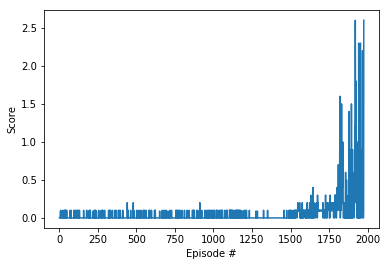

In [28]:
states = env_info.vector_observations
state_size = states.shape[1]
brain_name = env.brain_names[0]
brain = env.brains[brain_name]
action_size = brain.vector_action_space_size
num_agents = 2
agents = Agent(state_size, action_size, random_seed = 42, prio = False)

def ddpg_multiple(n_episodes = 10000, max_t = 10000, print_every = 20):  
    
    scores_deque = deque(maxlen = 100)
    scores = []  
    env_info = env.reset(train_mode=True)[brain_name] 
    t_step = 0
    memory = ReplayBuffer(action_size, BUFFER_SIZE, BATCH_SIZE, seed = 1)
        # this creates the replay buffer to be shared between the two agents
    
    for i_episode in range(1, n_episodes + 1):
        
        episode_scores = np.zeros(num_agents)                                # initialize/reset the episode scores
        env_info = env.reset()[brain_name]                                   # reset the environment   
        states = env_info.vector_observations                                # get the current state (for each agent)
                                                             
        for t in range(max_t):

            actions = agents.act(states, noise_factor = NOISE_FACTOR)        # agent selects its action
            env_info = env.step(actions)[brain_name]                         # the action is passed to the environment
            next_states = env_info.vector_observations                       # get next states 
            rewards = env_info.rewards                                       # get rewards
            dones = env_info.local_done                                      # see if episode finished
            episode_scores += env_info.rewards                               # update the agent scores       
            memory.add(states[0], actions[0], rewards[0], next_states[0], dones[0])  # add each experience tuple to the buffer
            memory.add(states[1], actions[1], rewards[1], next_states[1], dones[1])
            t_step = (t_step + 1) % LEARN_EVERY_T
            if t_step  == 0:                                                 # update model parameters every 'LEARN_EVERY_T'
                if len(memory)>BATCH_SIZE:                                           # timesteps
                    for j in range(UPDATES_EACH_STEP):
                        experiences = memory.sample()
                        agents.learn(experiences, GAMMA)             
            states = next_states                                             # next states becomes the current states
            if np.any(dones):                                                # exit loop if episode finished
                break       

        scores_deque.append(np.max(episode_scores))
        scores.append(np.max(episode_scores))
 
        if i_episode % print_every == 0:
            print('\rRolling 100 Episodes Ending Ep {}\tAverage Score: {:.2f}   \
                Last 5 Episode Scores: {:.1f}, {:.1f}, {:.1f}, {:.1f}, {:.1f}'.format(
                i_episode, np.mean(scores_deque), scores_deque[-5], scores_deque[-4], scores_deque[-3], 
                scores_deque[-2], scores_deque[-1]))

        if np.mean(scores_deque) >= 0.5:                                      # save models and break if environment solved
            print('Environment Solved in ', i_episode, ' episodes.')
            torch.save(agents.actor_local.state_dict(), 'checkpoint_actor.pth')
            torch.save(agents.critic_local.state_dict(), 'checkpoint_critic.pth')
            break
    return scores

scores = ddpg_multiple()

fig = plt.figure()
ax = fig.add_subplot(111)
plt.plot(np.arange(1, len(scores) + 1), scores)
plt.ylabel('Score')
plt.xlabel('Episode #')
plt.show()

<div class="alert alert-block alert-info">
<b>Insights from training:</b> <br>
<br>
As seen in the above line chart, the agents successfully solve the environment after 1,975 episodes.  The most important learnings were stated in section 7 as it pertains to hyperparameter tuning.  In addition to these, there were a couple of interesting phenomena that I observed.  First, it seems that simple networks (in terms of number of nodes per hidden layer) were more effective with higher learning rates, but several of my earlier attempts involved more complex networks with smaller learning rates and these attempts, while not ultimately successful, did perform better than combining complex networks with large learning rates and combining simple networks with smaller learning rates.  It's interesting that there seems to be an inverse relationship between network complexity and learning rates in terms of successful performance.  The second interesting phenomenon was that there were several attempts where my rolling average scores had higher performance earlier on, with long strings of 0.04 and/or 0.05 but ultimately did not achieve the "lift off" that the final solution did even though the final solution had respective rolling averages of around 0.01 beforehand.  I believe these earlier attempts resulted in the agents learning how to hit the ball one time really well, but not learning how to pass the ball back and forth and perform cooperatively.

</div>

### 10.  See the trained smart agents in action!

<br>
<br>
Run the below cell to see the intelligent agents in action.  The agents are trained to keep the ball in the air for as long as possible.
<br>
<br>
If your unity window closed from earlier, please shut down the kernel, relaunch the notebook and rerun all cells except the training cell above.

In [15]:

agents = Agent(state_size, action_size, random_seed = 42)
agents.actor_local.load_state_dict(torch.load('checkpoint_actor.pth'))
agents.critic_local.load_state_dict(torch.load('checkpoint_critic.pth'))
env_info = env.reset(train_mode=False)[brain_name]                    
states = env_info.vector_observations     
#state_size = states.shape[1]
while True:
    actions = agents.act(states, noise_factor = NOISE_FACTOR)     
    env_info = env.step(actions)[brain_name]         
    next_states = env_info.vector_observations
    rewards = env_info.rewards   
    dones = env_info.local_done
    states = next_states
    if np.any(dones):
        break
        

C:\Users\steph\Anaconda3-1\envs\DRL\lib\site-packages\torch\nn\functional.py:995: UserWarning: nn.functional.tanh is deprecated. Use torch.tanh instead.
  warnings.warn("nn.functional.tanh is deprecated. Use torch.tanh instead.")


<div class="alert alert-block alert-info">
<b>Ideas for improvement:</b> <br>
<br>
This solution utilizes a DDPG framework.  PPO or other actor-critic frameworks could be applied and could potentially result in an improved solution.  Another idea is to implement learning rate decay, starting training with large learning rates which gradually decline as the agents train and eventually stablize with very low learning rate values.  A noise decay parameter could be used as well along the same lines of logic.  Prioritized replay, Double Q networks or other Q-network improvements could also be applied to the critic networks which could potentially improve performance.
<br>
<br>
One radical change could involve feeding the output of convolutional neural networks in favor of environment states to the actor and critic networks.  This would behave similarly to prior Q-network achievements on Atari games seen in the literature where the agents learn from variations in screen pixels.

</div>

### 11.  Appendix / Code Not Used

I coded the below cells in prior attempts to find a solution.  In the end, these cells weren't necessary to complete the project.

In [26]:
class MADDPG:
    
    def __init__(self, gamma = GAMMA, tau = TAU, noise_decay = NOISE_DECAY, noise_factor = NOISE_FACTOR, noise_min = NOISE_MIN):
        

        
        self.gamma = gamma
        self.tau = tau
        self.iter = 0
        self.noise_decay = noise_decay
        self.noise_factor = noise_factor
        self.noise_min = noise_min
        
        self.maddpg_agent = [ Agent(state_size, action_size, random_seed = 1, prio = False, double_agent = 1),
                             Agent(state_size, action_size, random_seed = 1, prio = False, double_agent = 1) ]
        
    def get_actors(self):
        
        # retrieve actor networks from individual agents in maddp_agent
        
        local_actors = [agent.actor_local for agent in self.maddpg_agent]
        return local_actors
        
    def get_target_actors(self):
        
        # retrieve the target actor networks from individual agents in maddp_agent
        
        target_actors = [agent.actor_target for agent in self.maddpg_agent]
        return target_actors
        
    def act(self, states):
        
        # gets actions from all agents in maddpg_agent
        
        actions = [agent.act(state, self.noise_factor) for agent, state in zip(self.maddpg_agent, states)]
        return actions
    
    def target_act(self, next_states):
        
        # get target network actions from all agents in maddpg_agent
        
        target_actions = [agent.actor_target(next_state) for agent, next_state in zip(self.maddpg_agent, next_states)]
        return target_actions
    
    def update(self, experiences, agent_number, logger):
        
        # updates the critics and actors of all the agents
        
        states, actions, rewards, next_states, dones = experiences
        agent = self.maddpg_agent[agent_number]

        target_actions = agent.actor_target(next_states)
        Q_targets_next = agent.critic_target(next_states, target_actions)
        Q_targets = rewards + (self.gamma * Q_targets_next * (1 - dones))
        
        # compute the critic loss
        
        Q_expected = agent.critic_local(states, actions)
        critic_loss = F.mse_loss(Q_expected, Q_targets)
        
        # minimize the loss
        
        agent.critic_optimizer.zero_grad()
        critic_loss.backward()
        torch.nn.utils.clip_grad_norm_(agent.critic_local.parameters(), 1)
        agent.critic_optimizer.step()
        
        ###### update the actor ######
        
        # compute actor loss
        
        #actions_pred = [ self.maddpg_agent[i].actor_local(state) if i == agent_number else
        #               self.maddpg_agent[i].actor_local(state).detach() for i, state in enumerate(states)]
        actions_pred = agent.actor_local(states)
        actor_loss = -agent.critic_local(states, actions_pred).mean()
        actor_loss = Variable(actor_loss, requires_grad = True)
        
        # minimize the loss
        
        agent.actor_optimizer.zero_grad()
        actor_loss.backward()
        agent.actor_optimizer.step()
        
        ###### obtain info for torchboard ######
        
        al = actor_loss.cpu().detach().item()
        cl = critic_loss.cpu().detach().item()
        logger.add_scalar('critic_loss', cl, self.iter)
        logger.add_scalar('actor_loss', al, self.iter)
        
        ###### decay noise ######
        
        if (self.noise_factor - self.noise_decay) > self.noise_min:
            self.noise_factor -= self.noise_decay
        else:
            self.noise_factor = self.noise_min
            
        ###### option to decay learning rates ######
        agent.lr_actor *= agent.lr_decay
        agent.lr_critic *= agent.lr_decay
        
    def update_targets(self):
        
        # soft update of targets
        
        self.iter += 1
        for agent in self.maddpg_agent:
            agent.soft_update(agent.actor_target, agent.actor_local, self.tau)
            agent.soft_update(agent.critic_target, agent.critic_local, self.tau)
            